# LPFP algorithm for optimal stopping MFGs with common noise and partial information: electricity markets

## By Roxana Dumitrescu, Marcos Leutscher and Peter Tankov

See https://arxiv.org/abs/2210.03554

*Setting 2: Common noise without scenario uncertainty*

In this notebook we develop the *linear programming fictitious play algorithm* for MFGs of optimal stopping with common noise and partial information in an application to electricity markets. The inputs for the algorithm consist in the following data:

- Sets for: State conventional $E_1$, State renewable $E_2$, Noise $H$.
- An initial distribution of the conventional producers $m_0^*\in \mathcal P(E_1)$.
- An initial distribution of the renewable producers $\bar{m}_0^*\in \mathcal P(E_2)$.
- A terminal time $T>0$ and a number $N\geq 1$ for the discretisation of $[0, T]$.
- Parameters for the conventional producer: $C_{min}$, $C_{max}$, $k$, $\theta$, $\delta$.
- Parameters for the renewable producer: $R_{min}$, $R_{max}$, $\bar k$, $\bar \theta$, $\bar \delta$.
- $n_{jumps}$, $n\mapsto d(n)$, $\beta$, $\Pi_0$.
- $I_C$, $I_R$, $I_R^b$, $p\mapsto S^b(p)$, $p_{max}$.
- $\rho$.
- Reward conventional: $\tilde \beta$, $\kappa_C$, $K_C$, $\gamma_C$, $y\mapsto \bar \alpha(y)$, $c(1)$, $\tilde \beta$.
- Reward renewable: $\kappa_R$, $K_R$, $\gamma_R$.

At iteration $k$, the algorithm computes the best response $(\hat\mu^{(k+1)}, \hat m^{(k+1)})$ for a fixed distribution of the players $(\bar\mu^{(k)}, \bar m^{(k)})$ which influences the rewards. This step can be seen as a single-agent problem in the sense that for fixed $(\bar\mu^{(k)}, \bar m^{(k)})$, one solves a classical optimal stopping problem. Therefore, we use linear programming to compute the best response. 

Once the best response is calculated, we update our guess for the mean-field as it is suggested in the fictitious play framekork:
$$(\bar \mu^{(k+1)}, \bar m^{(k+1)}):=\frac{k}{k+1}(\bar \mu^{(k)}, \bar m^{(k)}) + \frac{1}{k+1}(\hat\mu^{(k+1)}, \hat m^{(k+1)}).$$

We import the following packages

In [1]:
# Package imports

import numpy as np
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import cm
import pandas as pd
import time
from scipy.stats import gamma, beta
from scipy.optimize import root_scalar
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from numpy.linalg import matrix_power
import gurobipy as gp
from gurobipy import GRB

## I. Best response

We start with the best response algorithm via linear programming.

## 1) Time and common noise

The time horizon for the game is 18 years and the time step is 3 months. We define the time indices.

In [2]:
# Time space

T = 18.  # in years
Time_step = 3  # in months
N = int(T * (12 / Time_step))
Time = np.arange(N+1)  # Time indices
Time = np.reshape(Time, (Time.shape[0], 1))
dt = T/N
print('Time', Time.T)

Time [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72]]


## Scenarios

The carbon price can jump up to the next state each 2 years and a half. We describe the space for the carbon price, the number of jumps and the scenarios.

In [3]:
# Noise space

time_jumps = 2.5 # There will be jumps each 2.5 years
n_jumps = 6      # 6 jumps
Noise = np.array([50, 75, 100, 125, 150, 175, 200])  # Carbon price state space
Noise = np.reshape(Noise, (Noise.shape[0], 1))
z_0 = Noise[0, 0]
print('Noise', Noise.T)

Noise [[ 50  75 100 125 150 175 200]]


In [4]:
# Jump times

J = [int(time_jumps*int(N/T)*(n+1)) for n in range(n_jumps)]
print('Jump times', J)

Jump times [10, 20, 30, 40, 50, 60]


The scenarios are indexed as follows:

- 0: 0.5 of proba to stay

In [5]:
ns = 1
Scenarios= np.arange(ns)
Scenarios = Scenarios.reshape(-1, 1)
print(Scenarios.T)
Prior = np.ones((ns, 1))/ns
print(Prior.T)

[[0]]
[[1.]]


We define now the probability that the carbon price does not jump in a jump date given each scenario.

In [6]:
P_S = []
P_S.append(np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))
print(P_S)

[array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])]


We define the transition kernel of the carbon price given the scenario.

In [7]:
def pi_noise(n, z, Z, s):
    """
    Argument:
    n -- time
    z -- present state index
    Z -- future state index
    s -- scenario
    
    Returns:
    P -- probability of going from z to Z under the scenario s
    """
    
    if any(np.allclose(n, k) for k in J) and (Noise[z, 0] < Noise[-1, 0]):
        index = J.index(int(n))
        if np.allclose(Z, z):
            P = P_S[s][index]
        elif np.allclose(Z, z+1):
            P = 1 - P_S[s][index]
        else:
            P = 0.
        
    else:
        if np.allclose(Z, z):
            P = 1.
        else:
            P = 0.   
    return P

pi_noise = np.vectorize(pi_noise, otypes=[float])

We compute the collection of realizable sample paths of the common noise process together with the corresponding probability. 

In [8]:
def loop_rec(n):
    """
    Argument:
    n -- time
    
    Returns:
    Noise_paths -- list of all possible common noise paths up to time n
    Noise_proba -- list of all the probabilities associated to the common noise paths up to time n for each scenario
    """
    
    if n == 0:
        Noise_paths = [np.array([[0]])]
        Noise_proba = [np.ones((ns, 1))]
    else:
        Paths, Proba = loop_rec(n - 1)
        Noise_paths = []
        Noise_proba = []
        for k in range(len(Paths)):
            z = Paths[k][-1, 0]
            for i in range(Noise.shape[0]):
                P = pi_noise(n, z, i, Scenarios)
                if np.any(P > 0):
                    Noise_paths.append(np.append(Paths[k], np.array([[i]]), axis = 0))
                    Noise_proba.append(Proba[k]*P)
                    
    return Noise_paths, Noise_proba

def paths_proba(n):
    """
    Argument:
    n -- time
    
    Returns:
    Noise_paths -- list of all possible common noise paths up to time n
    Noise_proba -- list of all the probabilities associated to the common noise paths up to time n
    """
    
    Noise_paths, Noise_proba = loop_rec(n)
    
    for k in range(len(Noise_proba)):
            Noise_proba[k] = np.sum(Noise_proba[k]*Prior, axis = 0)
    
    return Noise_paths, Noise_proba

In [9]:
# Noise paths space

Noise_paths, Noise_proba = paths_proba(N)

n_c = len(Noise_paths)  # Total number of common noise paths

For example, we can select the third path and obtain its values at each time together with the probability that the common noise takes this path.

In [10]:
print(Noise[Noise_paths[3], 0].T)
print(Noise_proba[3])

[[ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
   50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
   50  50  50  50  50  50  50  50  50  50  50  50  50  50  75  75  75  75
   75  75  75  75  75  75 100 100 100 100 100 100 100 100 100 100 100 100
  100]]
[0.015625]


We can visualize all the common noise paths as follows.

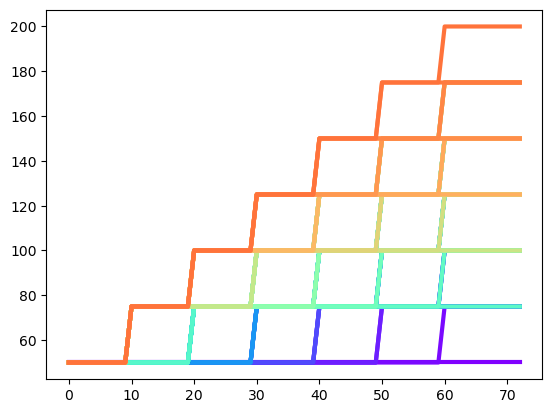

In [11]:
colors = iter(cm.rainbow(np.linspace(0, 0.85, n_c)))

for counter_noise in range(len(Noise_paths)):
    plt.plot(Time[:, 0], Noise[Noise_paths[counter_noise], 0], color = next(colors), linewidth = 3)
plt.show()

We define the map $U$ which associates to each path its history in matrix form, up to time $n$.

In [12]:
def U(n, omega):
    """
    Argument:
    n -- time
    omega -- common noise path
    
    Returns:
    U -- matrix of bits characterizing the path omega up to time n
    """
    U = np.zeros((Time.shape[0], Noise.shape[0]))
    for i in range(n+1):
        for k in range(Noise.shape[0]):
            U[i, k] = (omega[i, 0] == k)
    return U

For example:

In [13]:
print(U(60, Noise_paths[-1]))

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.

We define the set of all possible values of $U_n$ and the associated probabilities at time $n$, denoted by $\Omega_n$ and $p_n(u)$, $u\in \Omega_n$ in the article.

In [14]:
def Omega_proba(n):
    """
    Argument:
    n -- time
    
    Returns:
    Omega -- List with the elements of \Omega_n
    Proba -- List containing the probabilities (p_n(u))_u
    """
    Omega = []
    Proba = []
    
    Noise_paths, Noise_proba = paths_proba(n)
    for k in range(len(Noise_paths)):
        Omega.append(U(n, Noise_paths[k]))
        Proba.append(Noise_proba[k])
    return Omega, Proba

We create a list containing the cardinal of $\Omega_n$, a list containing the $u\in \Omega_n$ and list containing the $p_n(u)$.

In [15]:
len_Omega = []
Omega_list = []
Omega_proba_list = []

for n in range(Time.shape[0]):
    Omega, Proba = Omega_proba(n)
    len_Omega.append(len(Omega))
    Omega_list.append(Omega)
    Omega_proba_list.append(Proba)

In [89]:
np.save('Omega_proba_list2', Omega_proba_list, allow_pickle = True)

We define the functions $\psi_n$ verifying $\psi_k(U_n)=Z_k$, for $k\leq n$.

In [16]:
def psi(n, U):
    """
    Argument:
    n -- time
    U -- matrix of bits characterizing the path omega up to time n
    
    Returns:
    Associated value in $H$
    """
    row = U[n, :]
    z_index = np.nonzero(row)[0]
    if z_index.shape[0] > 0:
        return Noise[z_index[0], 0]
    else:
        return 0.

We compute the transition kernels of $U$, which are given by
$$\pi_n^U(u, u')= \mathbb P(U_n = u'|U_{n-1}=u)=\mathbb{1}_{u[:n-1, :]= u'[:n-1, :]}\frac{\mathbb P(U_n=u')}{\mathbb P(U_{n-1}=u)}.$$

In [17]:
def pi_U(n, u_index, U_index):
    """
    Argument:
    n -- time
    u_index -- index of element in Omega_{n-1}
    U_index -- index of element in Omega_{n}
    
    Returns:
    P -- probability of going from u_index to U_index
    """
    u = Omega_list[n-1][u_index]
    U = Omega_list[n][U_index]
    
    if np.allclose(u[:n, :], U[:n, :]):
        P = Omega_proba_list[n][U_index]/Omega_proba_list[n-1][u_index]
    else:
        P = np.array([0.])
            
    return P

pi_U = np.vectorize(pi_U, otypes=[float]) 

## 2) States

We describe the dynamics of the conventional and renewable producers.

In [18]:
# Conventional

C_min = 0.
C_max = 70.

t_beta = 0.429 # in tonCO2/MWh

theta = 37.94 * 0.88 - t_beta * z_0  #0.88 is the conversion of euros to GBP
stdC = 12.53 * 0.88
k = 0.5
delta = stdC * np.sqrt(2. * k / theta)

dC = delta * np.sqrt(theta * dt)
n_1 = int(np.ceil((C_max - C_min) / dC))

E_1 = np.linspace(C_min, C_max, num = n_1 + 1)
E_1 = np.reshape(E_1, (E_1.shape[0], 1))
dC = E_1[1, 0] - E_1[0, 0]

m0 = gamma.pdf(E_1, a = 2*theta*k/(delta**2), scale = delta**2/(2*k))
m0 = m0/np.sum(m0)

# Renewable

R_min = 0.3
R_max = 0.6

bartheta= 0.4261
stdR = 0.0443   
bark = 0.5
bardelta = stdR * np.sqrt(2. * bark / (bartheta * (1 - bartheta) - stdR**2))

dR = bardelta * np.sqrt(bartheta * (1 - bartheta) * dt)
n_2 = int(np.ceil((R_max - R_min) / dR))

E_2 = np.linspace(R_min, R_max, num = n_2 + 1)
E_2 = np.reshape(E_2, (E_2.shape[0], 1))
dR = E_2[1, 0] - E_2[0, 0]

barm0 = beta.pdf(E_2, a = 2*bark*bartheta/(bardelta**2), b = 2*bark*(1-bartheta)/(bardelta**2))
barm0 = barm0/np.sum(barm0)

The following functions define the transition kernel of the conventional producer.

In [19]:
# Dynamics conventional

def b(x):
    return k * (theta - x)

def sigma(x):
    return delta * x**(1/2)

def pi_B(x, X):
    if np.allclose(x, E_1[0, 0]):
        if np.allclose(X, E_1[1, 0]):
            P = 1.
        else:
            P = 0.
    elif np.allclose(x, E_1[-1, 0]):
        if np.allclose(X, E_1[-2, 0]):
            P = 1.
        else:
            P = 0.
    else:
        if np.allclose(X, x + dC): 
            P = (sigma(x)**2/2 + dC*np.maximum(b(x), 0))/(sigma(x)**2 + dC*np.abs(b(x)))
        elif np.allclose(X, x - dC): 
            P = (sigma(x)**2/2 - dC*np.minimum(b(x), 0))/(sigma(x)**2 + dC*np.abs(b(x)))
        else:
            P = 0.
    return P   

The following functions define the transition kernel of the renewable producer.

In [20]:
# Dynamics renewable

def bar_b(x):
    return bark*(bartheta-x)

def bar_sigma(x):
    return bardelta*(x*(1-x))**(1/2)

def pi_R(x, X):
    if np.allclose(x, E_2[0, 0]):
        if np.allclose(X, E_2[1, 0]):
            P = 1.
        else:
            P = 0.
    elif np.allclose(x, E_2[-1, 0]):
        if np.allclose(X, E_2[-2, 0]):
            P = 1.
        else:
            P = 0.
    else:
        if np.allclose(X, x + dR): 
            P = (bar_sigma(x)**2/2 + dR*np.maximum(bar_b(x), 0))/(bar_sigma(x)**2 + dR*np.abs(bar_b(x)))
        elif np.allclose(X, x - dR): 
            P = (bar_sigma(x)**2/2 - dR*np.minimum(bar_b(x), 0))/(bar_sigma(x)**2 + dR*np.abs(bar_b(x)))
        else:
            P = 0.
    return P   

## 3) Constraints

We generate a linear constraint of the form $Ax=b$ for each producer, where $x=(\mu, m)^T$.

In [21]:
len_mu_C = 0
for n in range(Time.shape[0]):
    len_mu_C += len_Omega[n]*E_1.shape[0]
    
print(len_mu_C)

20468


In [22]:
len_mu_R = 0
for n in range(Time.shape[0]):
    len_mu_R += len_Omega[n]*E_2.shape[0]
    
print(len_mu_R)

21930


In [23]:
%%time 
# A_mu

A_mu_C = []

for n0 in range(Time.shape[0]):
    for i in range(len_Omega[n0]): 
        for j in range(E_1.shape[0]): 
            L = [np.zeros((1, len_Omega[n]*E_1.shape[0])) for n in range(Time.shape[0])]
            B = np.zeros((len_Omega[n0], E_1.shape[0]))
            B[i, j] = Omega_proba_list[n0][i]
            L[n0] = B.reshape(1,-1)
            A_mu_C.append(np.concatenate(L, axis = 1))
                
A_mu_C = np.concatenate(A_mu_C, axis = 0)

A_mu_C = csr_matrix(A_mu_C)

scipy.sparse.save_npz('matrices/A_mu_C', A_mu_C)

Wall time: 44.7 s


In [24]:
A_mu_C = scipy.sparse.load_npz('matrices/A_mu_C.npz')

In [25]:
%%time 

A_m_0_C = []

for n0 in range(Time.shape[0]):
    for i in range(len_Omega[n0]): 
        for j in range(E_1.shape[0]): 
            L = [np.zeros((1, len_Omega[n]*E_1.shape[0])) for n in range(Time.shape[0]-1)]
            if n0<N:
                B = np.zeros((len_Omega[n0], E_1.shape[0]))
                B[i, j] = -Omega_proba_list[n0][i]
                L[n0] = B.reshape(1,-1)
            A_m_0_C.append(np.concatenate(L, axis = 1))
                    
A_m_0_C = np.concatenate(A_m_0_C, axis = 0)

A_m_0_C = csr_matrix(A_m_0_C)

scipy.sparse.save_npz('matrices/A_m_0_C', A_m_0_C)

Wall time: 17.6 s


In [26]:
A_m_0_C = scipy.sparse.load_npz('matrices/A_m_0_C.npz')

To accelerate the computation of the transition kernel integral, we sum only over all possible previous states.

In [27]:
def past_U(n, U_index):
    past = []
    U = Omega_list[n][U_index]
    for i in range(len_Omega[n-1]):
        u = Omega_list[n-1][i]
        if np.allclose(u[:n, :], U[:n, :]):
            past.append(i)
    return past

In [28]:
def past_B(X_index):
    if (X_index > 0) and (X_index < E_1.shape[0]-1):
        return [X_index - 1, X_index + 1]
    elif X_index == 0:
        return [1]
    else:
        return [E_1.shape[0]-2]

In [29]:
def past_R(X_index):
    if (X_index > 0) and (X_index < E_2.shape[0]-1):
        return [X_index - 1, X_index + 1]
    elif X_index == 0:
        return [1]
    else:
        return [E_2.shape[0]-2]

In [30]:
%%time

A_m_C = []

for n0 in range(Time.shape[0]):
    for i in range(len_Omega[n0]): 
        for j in range(E_1.shape[0]): 
            L = [np.zeros((1, len_Omega[n]*E_1.shape[0])) for n in range(Time.shape[0]-1)]
            if n0 > 0:
                B = np.zeros((len_Omega[n0-1], E_1.shape[0]))
                for i1 in past_U(n0, i): 
                    for j1 in past_B(j):
                        B[i1, j1] = Omega_proba_list[n0-1][i1]*pi_B(E_1[j1, 0], E_1[j, 0])*pi_U(n0, i1, i)
                L[n0-1] = B.reshape(1,-1)
            A_m_C.append(np.concatenate(L, axis = 1))

            
A_m_C = np.concatenate(A_m_C, axis = 0)  

A_m_C = csr_matrix(A_m_C)

scipy.sparse.save_npz('matrices/A_m_C', A_m_C)

Wall time: 57.8 s


In [31]:
A_m_C = scipy.sparse.load_npz('matrices/A_m_C.npz')

In [32]:
A_eq_C = hstack((A_mu_C, -(A_m_0_C + A_m_C)))

A_eq_C = csr_matrix(A_eq_C)

scipy.sparse.save_npz('matrices/A_eq_C', A_eq_C)

In [33]:
b_eq_C = []

for n0 in range(Time.shape[0]):
    for i in range(len_Omega[n0]): 
        for j in range(E_1.shape[0]): 
            if n0 == 0:
                b_eq_C.append(m0[j, :])
            else:
                b_eq_C.append(np.array([0.]))
                    
b_eq_C = np.concatenate(b_eq_C, axis = 0)

b_eq_C = b_eq_C.reshape((b_eq_C.shape[0], 1))

b_eq_C = csr_matrix(b_eq_C)

scipy.sparse.save_npz('matrices/b_eq_C', b_eq_C)

In [34]:
b_eq_C = scipy.sparse.load_npz('matrices/b_eq_C.npz')

b_eq_C = b_eq_C.toarray()

In [35]:
%%time 
# A_mu

A_mu_R = []

for n0 in range(Time.shape[0]):
    for i in range(len_Omega[n0]): 
        for j in range(E_2.shape[0]): 
            L = [np.zeros((1, len_Omega[n]*E_2.shape[0])) for n in range(Time.shape[0])]
            B = np.zeros((len_Omega[n0], E_2.shape[0]))
            B[i, j] = Omega_proba_list[n0][i]
            L[n0] = B.reshape(1,-1)
            A_mu_R.append(np.concatenate(L, axis = 1))
                
A_mu_R = np.concatenate(A_mu_R, axis = 0)

A_mu_R = csr_matrix(A_mu_R)

scipy.sparse.save_npz('matrices/A_mu_R', A_mu_R)

Wall time: 32.8 s


In [36]:
A_mu_R = scipy.sparse.load_npz('matrices/A_mu_R.npz')

In [37]:
%%time 

A_m_0_R = []

for n0 in range(Time.shape[0]):
    for i in range(len_Omega[n0]): 
        for j in range(E_2.shape[0]): 
            L = [np.zeros((1, len_Omega[n]*E_2.shape[0])) for n in range(Time.shape[0]-1)]
            if n0<N:
                B = np.zeros((len_Omega[n0], E_2.shape[0]))
                B[i, j] = -Omega_proba_list[n0][i]
                L[n0] = B.reshape(1,-1)
            A_m_0_R.append(np.concatenate(L, axis = 1))
                    
A_m_0_R = np.concatenate(A_m_0_R, axis = 0)

A_m_0_R = csr_matrix(A_m_0_R)

scipy.sparse.save_npz('matrices/A_m_0_R', A_m_0_R)

Wall time: 27.5 s


In [38]:
A_m_0_R = scipy.sparse.load_npz('matrices/A_m_0_R.npz')

In [39]:
%%time

A_m_R = []

for n0 in range(Time.shape[0]):
    for i in range(len_Omega[n0]): 
        for j in range(E_2.shape[0]): 
            L = [np.zeros((1, len_Omega[n]*E_2.shape[0])) for n in range(Time.shape[0]-1)]
            if n0>0:
                B = np.zeros((len_Omega[n0-1], E_2.shape[0]))
                for i1 in past_U(n0, i):  
                    for j1 in past_R(j):
                        B[i1, j1] = Omega_proba_list[n0-1][i1]*pi_R(E_2[j1, 0], E_2[j, 0])*pi_U(n0, i1, i)
                L[n0-1] = B.reshape(1,-1)
            A_m_R.append(np.concatenate(L, axis = 1))
                    
A_m_R = np.concatenate(A_m_R, axis = 0)  

A_m_R = csr_matrix(A_m_R)

scipy.sparse.save_npz('matrices/A_m_R', A_m_R)

Wall time: 1min 12s


In [40]:
A_m_R = scipy.sparse.load_npz('matrices/A_m_R.npz')

In [41]:
A_eq_R = hstack((A_mu_R, -(A_m_0_R + A_m_R)))

A_eq_R = csr_matrix(A_eq_R)

scipy.sparse.save_npz('matrices/A_eq_R', A_eq_R)

In [42]:
b_eq_R = []

for n0 in range(Time.shape[0]):
    for i in range(len_Omega[n0]): 
        for j in range(E_2.shape[0]): 
            if n0 == 0:
                b_eq_R.append(barm0[j, :])
            else:
                b_eq_R.append(np.array([0.]))
                    
b_eq_R = np.concatenate(b_eq_R, axis = 0)

b_eq_R = b_eq_R.reshape((b_eq_R.shape[0], 1))

b_eq_R = csr_matrix(b_eq_R)

scipy.sparse.save_npz('matrices/b_eq_R', b_eq_R)

In [43]:
b_eq_R = scipy.sparse.load_npz('matrices/b_eq_R.npz')

b_eq_R = b_eq_R.toarray()

## 4) Reward functions

We create the reward functions for both types of producers.

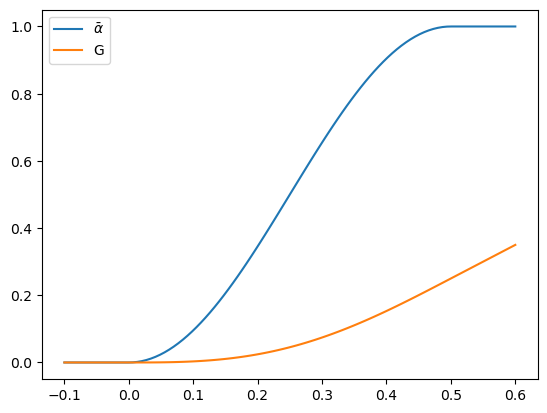

In [21]:
## Bidding function

c_max = 0.5

def bar_alpha(x):
    return (x > c_max) + 1/2*(1 + np.sin(-np.pi/2 + np.pi/c_max*x))*(0 <= x <= c_max)

bar_alpha = np.vectorize(bar_alpha)
x0 = np.linspace(-0.1, 0.6, 100)
plt.plot(x0, bar_alpha(x0), label=r"$\bar \alpha$")

## Gain function

def Gain(x):
    return (x-c_max/2)*(x > c_max) + 1/2*(x-c_max/np.pi*np.cos(-np.pi/2 + np.pi/c_max*x))*(0 <= x <= c_max)

Gain = np.vectorize(Gain)
plt.plot(x0, Gain(x0), label = "G")
plt.legend();

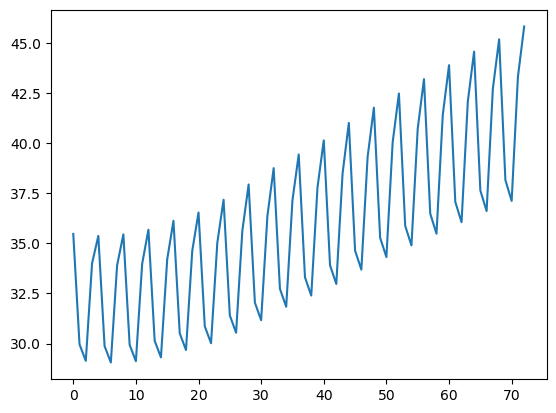

In [22]:
# Demand

beta_factor = 0.015

D = pd.read_excel("Demand_array.xlsx", decimal=',', header=None)
D = D.to_numpy()
D = D.reshape(-1)

sc = np.array([1.10352635, 0.93209028, 0.90656527, 1.05781809])
Lambda = np.tile(sc, int(T))
Lambda = np.append(Lambda, sc[0])

# Adjusting for seasonal cycle

d = np.zeros(73)
for i in range(int(T)): 
    d[i*4:(i+1)*4] = D[i]  
d[-1] = D[-1]

r_d = 1.2875630406414182 # peak / offpeak demand ratio
c_p = 65./168. # peak hours
c_o = 1. - c_p

bar_c_p = r_d/(c_p*r_d+c_o)
bar_c_o = 1/(c_p*r_d+c_o)

plt.plot(np.arange(d.shape[0]), Lambda*d);

In [23]:
# Capacities, cap price and baseline conventional supply

I_C = 35.9
I_R_b = 35.6
I_R = 47.

p_max = 150.

def S_b(x):
    return 12.1/p_max*x

In [24]:
# Costs and rates

rho = 0.086

kappa_C = 30.
K_C = 0.
gamma_C = np.log(2.)/30.

K_R = 1377.
kappa_R = 0.0125 * 1377.
gamma_R = np.log(2.)/10.

convcoef = 24.*365.25/1000. # GBP/MWh = convcoef GBP/kWyr

In [25]:
# Transition matrix of R to compute E[R_n]

Q = np.zeros((E_2.shape[0], E_2.shape[0]))

for i in range(E_2.shape[0]):
    for j in range(E_2.shape[0]):
        Q[i, j] = pi_R(E_2[i], E_2[j])

mean_R = []

for n in range(Time.shape[0]):
    Q_n = matrix_power(Q, n)
    mean_R_n = np.matmul(np.matmul(barm0.T, Q_n), E_2)
    mean_R.append(mean_R_n)

In [26]:
def S_c(m):
    def Supply_C(z, p):
        return I_C * np.sum(bar_alpha(p - E_1 - t_beta*z)*m) + S_b(p)
    return Supply_C

def S_r(n, bar_m):
    return (I_R_b + I_R) * mean_R[n] - I_R * np.sum(E_2 * bar_m)

In [27]:
def bar_P(n, z, d, m, bar_m):
    Supply_R = S_r(n, bar_m)
    Supply_C = S_c(m)
    if d - Supply_R <= 0:
        p_star = 0
    elif d - Supply_R - Supply_C(z, p_max) > 0:
        p_star = p_max
    else:
        def res_demand(p):
            return d - Supply_R - Supply_C(z, p)
        p_star = root_scalar(res_demand, bracket = [0, p_max], x0 = p_max/2).root
    return p_star

In [28]:
def f(n, x, z, p_1, p_2):
    return np.exp(-rho*n*dt)*(convcoef*(c_p*Gain(p_1-x-t_beta*z) + c_o*Gain(p_2-x-t_beta*z))-kappa_C)*dt

In [29]:
def g(n):
    return K_C * np.exp(-(gamma_C + rho) * n * dt)

In [30]:
def bar_f(n, x, p_1, p_2):
    return -np.exp(-rho*n*dt)*(convcoef*(c_p*p_1 + c_o*p_2)*x - kappa_R)*dt

In [31]:
def bar_g(n):
    return K_R * np.exp(-rho*T -gamma_R*(T- n * dt)) - K_R*np.exp(-rho*n*dt)

In [55]:
G = []

for n in range(Time.shape[0]):
    for i in range(len_Omega[n]): 
        for j in range(E_1.shape[0]): 
            G.append(Omega_proba_list[n][i]*g(n))
                    
G = np.concatenate(G, axis = 0)

G = G.reshape((G.shape[0], 1))

np.save('matrices/G', G)

In [56]:
G = np.load('matrices/G.npy')

In [57]:
def F_generator(m, bar_m):

    F = []
    
    bar_F = []

    for n in range(Time.shape[0]-1):
        for i in range(len_Omega[n]): 
            p_price = bar_P(n, psi(n, Omega_list[n][i]), 
                            Lambda[n]*bar_c_p*(d[n] + beta_factor * (psi(n, Omega_list[n][i])-z_0)),
                            m[n][i], bar_m[n][i])
            op_price = bar_P(n, psi(n, Omega_list[n][i]), 
                             Lambda[n]*bar_c_o*(d[n] + beta_factor * (psi(n, Omega_list[n][i])-z_0)), 
                             m[n][i], bar_m[n][i])
            
            for j in range(E_1.shape[0]): 
                F.append(Omega_proba_list[n][i]*f(n, E_1[j, 0], psi(n, Omega_list[n][i]), p_price, op_price))
                
            for j1 in range(E_2.shape[0]): 
                bar_F.append(Omega_proba_list[n][i]*bar_f(n, E_2[j1, 0], p_price, op_price))
                        
    F = np.concatenate(F, axis = 0)
    
    F = F.reshape((F.shape[0], 1))
                    
    bar_F = np.concatenate(bar_F, axis = 0)
    
    bar_F = bar_F.reshape((bar_F.shape[0], 1))
    
    return F, bar_F

In [58]:
bar_G = []

for n in range(Time.shape[0]):
    for i in range(len_Omega[n]): 
        for j in range(E_2.shape[0]): 
            bar_G.append(Omega_proba_list[n][i]*bar_g(n))
                                            
bar_G = np.concatenate(bar_G, axis = 0)

bar_G = bar_G.reshape((bar_G.shape[0], 1))

np.save('matrices/bar_G', bar_G)

In [59]:
bar_G = np.load('matrices/bar_G.npy')

## 5) Interior point algorithm

To solve the linear programming problems we use Gurobi's LP solver (a free academic license is available). 

In [60]:
def best_response_C(F):
    reward = np.concatenate([G, F], axis = 0)
    
    model = gp.Model()
    model.Params.LogToConsole = 0
    rows, cols = len(b_eq_C), len(reward)
    variables = []
    for j in range(cols):
        variables.append(model.addVar(lb=0, ub=1, obj=reward[j, 0]))
    model.update()
    
    # iterate over the rows of S adding each row into the model
    for i in range(rows):
        start = A_eq_C.indptr[i]
        end = A_eq_C.indptr[i+1]
        variables_row = [variables[j] for j in A_eq_C.indices[start:end]]
        coeff = A_eq_C.data[start:end]
        expr = gp.LinExpr(coeff, variables_row)
        model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=b_eq_C[i, 0])
    
    model.update()
    model.ModelSense = -1
    model.optimize()
    
    sol = [variables[j].X for j in range(cols)]

    mu_raw = sol[:len_mu_C]
    m_raw = sol[len_mu_C:]
        
    mu_new = []
    for n in range(Time.shape[0]):
        mu_new_n = []
        for i in range(len_Omega[n]): 
            MU = np.zeros((E_1.shape[0], 1))
            for j in range(E_1.shape[0]): 
                MU[j, 0] = mu_raw[0]
                mu_raw = mu_raw[1:]
            mu_new_n.append(MU)
        mu_new.append(mu_new_n)

        
    m_new = []
    for n in range(Time.shape[0]-1):
        m_new_n = []
        for i in range(len_Omega[n]): 
            M = np.zeros((E_1.shape[0], 1))
            for j in range(E_1.shape[0]): 
                M[j, 0] = m_raw[0]
                m_raw = m_raw[1:]
            m_new_n.append(M)
        m_new.append(m_new_n)
                        
    return mu_new, m_new, model.ObjVal

In [61]:
def best_response_R(bar_F):
    reward = np.concatenate([bar_G, bar_F], axis = 0)
    
    model = gp.Model()
    model.Params.LogToConsole = 0
    rows, cols = len(b_eq_R), len(reward)
    variables = []
    for j in range(cols):
        variables.append(model.addVar(lb=0, ub=1, obj=reward[j, 0]))
    model.update()
    
    # iterate over the rows of S adding each row into the model
    for i in range(rows):
        start = A_eq_R.indptr[i]
        end = A_eq_R.indptr[i+1]
        variables_row = [variables[j] for j in A_eq_R.indices[start:end]]
        coeff = A_eq_R.data[start:end]
        expr = gp.LinExpr(coeff, variables_row)
        model.addLConstr(lhs=expr, sense=GRB.EQUAL, rhs=b_eq_R[i, 0])
    
    model.update()
    model.ModelSense = -1
    model.optimize()
    
    sol = [variables[j].X for j in range(cols)]
    
    mu_raw = sol[:len_mu_R]
    m_raw = sol[len_mu_R:]
    
    mu_new = []
    for n in range(Time.shape[0]):
        mu_new_n = []
        for i in range(len_Omega[n]): 
            MU = np.zeros((E_2.shape[0], 1))
            for j in range(E_2.shape[0]): 
                MU[j, 0] = mu_raw[0]
                mu_raw = mu_raw[1:]
            mu_new_n.append(MU)
        mu_new.append(mu_new_n)
        
    m_new = []
    for n in range(Time.shape[0]-1):
        m_new_n = []
        for i in range(len_Omega[n]): 
            M = np.zeros((E_2.shape[0], 1))
            for j in range(E_2.shape[0]): 
                M[j, 0] = m_raw[0]
                m_raw = m_raw[1:]
            m_new_n.append(M)
        m_new.append(m_new_n)
                        
    return mu_new, m_new, model.ObjVal

## II. Fictitious Play

The following function implements the Fictitious Play procedure where the best responses are obtained by solving LP problems.

In [65]:
def fictitious_play(guess_mu_0, guess_m_0, guess_mu_bar_0, guess_m_bar_0, tol, N_iter):
    """
    Argument: 
    guess_mu_0 -- initial guess for mu conventional
    guess_m_0 -- initial guess for m conventional
    guess_mu_bar_0 -- initial guess for mu renewable
    guess_m_bar_0 -- initial guess for m renewable
    tol -- error tolerance
    N_iter -- Maximum number of iterations
    
    Returns:
    List_C -- List containing guess_mu, guess_m, mu, m
    List_R -- List containing guess_mu_bar, guess_m_bar, mu_bar, m_bar
    List_error -- List containing explo_C, explo_R, eps_array
    """
    F, bar_F = F_generator(guess_m_0, guess_m_bar_0)
            
    guess_mu, guess_m, maximum = best_response_C(F)
            
    guess_mu_bar, guess_m_bar, maximum_bar = best_response_R(bar_F)
    
    eps = tol + 1
    
    eps_list = []
    eps_C_list = []
    eps_R_list = []
    
    explo_C = []
    explo_R = []
    
    n_iter = 1
    
    message_1 = "Iteration: {:4d}; Exploitability Conventional:  {:.2f}; Exploitability Renewable: {:.2f}"
    message_2 = "Rel error Conventional:  {:.4f}; Rel error Renewable: {:.4f}; Maximum: {:.4f}"
    
    while (eps > tol) and (n_iter <= N_iter):
            
        F, bar_F = F_generator(guess_m, guess_m_bar)
            
            
        mu, m, maximum = best_response_C(F)

        mu_bar, m_bar, maximum_bar = best_response_R(bar_F)

        # Exploitability Conventional            

        guess_mu_raw = []
        for n in range(Time.shape[0]):
            for i in range(len_Omega[n]):
                for j in range(E_1.shape[0]): 
                    guess_mu_raw.append(guess_mu[n][i][j, 0])

        guess_mu_raw = np.array(guess_mu_raw)
        guess_mu_raw = guess_mu_raw.reshape((guess_mu_raw.shape[0], 1)) #(-1, 1) reshape


        guess_m_raw = []
        for n in range(Time.shape[0]-1):
            for i in range(len_Omega[n]):
                for j in range(E_1.shape[0]): 
                    guess_m_raw.append(guess_m[n][i][j, 0])

        guess_m_raw = np.array(guess_m_raw)
        guess_m_raw = guess_m_raw.reshape((guess_m_raw.shape[0], 1))

        guess_value = np.matmul(G.T, guess_mu_raw) + np.matmul(F.T, guess_m_raw)
        guess_value = guess_value[0, 0]        

        exploitability = maximum - guess_value
        explo_C.append(exploitability)
        eps_n_C = exploitability / np.abs(guess_value)


        # Exploitability Renewable

        guess_mu_bar_raw = []
        for n in range(Time.shape[0]):
            for i in range(len_Omega[n]):
                for j in range(E_2.shape[0]): 
                    guess_mu_bar_raw.append(guess_mu_bar[n][i][j, 0])

        guess_mu_bar_raw = np.array(guess_mu_bar_raw)
        guess_mu_bar_raw = guess_mu_bar_raw.reshape((guess_mu_bar_raw.shape[0], 1))


        guess_m_bar_raw = []
        for n in range(Time.shape[0]-1):
            for i in range(len_Omega[n]):
                for j in range(E_2.shape[0]): 
                    guess_m_bar_raw.append(guess_m_bar[n][i][j, 0])

        guess_m_bar_raw = np.array(guess_m_bar_raw)
        guess_m_bar_raw = guess_m_bar_raw.reshape((guess_m_bar_raw.shape[0], 1))

        guess_bar_value = np.matmul(bar_G.T, guess_mu_bar_raw) + np.matmul(bar_F.T, guess_m_bar_raw)
        guess_bar_value = guess_bar_value[0, 0]


        exploitability_bar = maximum_bar - guess_bar_value
        explo_R.append(exploitability_bar)
        eps_n_R = exploitability_bar / np.abs(guess_bar_value)

        # Relative errors
        eps_n = max(eps_n_C, eps_n_R)
        eps_list.append(eps_n)
        eps_C_list.append(eps_n_C)
        eps_R_list.append(eps_n_R)

        # NEW GUESS
        for n in range(Time.shape[0]):
            for i in range(len_Omega[n]):
                guess_mu[n][i] = n_iter/(n_iter+1)*guess_mu[n][i] + 1/(n_iter+1)*mu[n][i]
                guess_mu_bar[n][i] = n_iter/(n_iter+1)*guess_mu_bar[n][i] + 1/(n_iter+1)*mu_bar[n][i]
                if n < N:
                    guess_m[n][i] = n_iter/(n_iter+1)*guess_m[n][i] + 1/(n_iter+1)*m[n][i]
                    guess_m_bar[n][i] = n_iter/(n_iter+1)*guess_m_bar[n][i] + 1/(n_iter+1)*m_bar[n][i]

        print(message_1.format(n_iter, exploitability, exploitability_bar))
        print(message_2.format(eps_n_C, eps_n_R, eps_n))

        
        eps = eps_n
        n_iter += 1
        
    eps_array = np.array(eps_list)
    eps_C_array = np.array(eps_C_list)
    eps_R_array = np.array(eps_R_list)
    explo_C = np.array(explo_C)
    explo_R = np.array(explo_R)
    
        
    List_C = [guess_mu, guess_m, mu, m]
    List_R = [guess_mu_bar, guess_m_bar, mu_bar, m_bar]
    
    List_error = [explo_C, explo_R, eps_array]

    return List_C, List_R, List_error

## III. Results

We give a preliminary initial guess and apply the LPFP algorithm to our model.

In [66]:
# Preliminary initial guess

# Conventional
guess_mu_0 = []
for n in range(Time.shape[0]):
    guess_mu_0_n = []
    for i in range(len_Omega[n]):
        A = np.ones((E_1.shape[0], 1))
        guess_mu_0_n.append(A/np.sum(A))
    guess_mu_0.append(guess_mu_0_n)
    
guess_m_0 = []
for n in range(Time.shape[0]-1):
    guess_m_0_n = []
    for i in range(len_Omega[n]):
        A = np.ones((E_1.shape[0], 1))
        guess_m_0_n.append(A/np.sum(A))
    guess_m_0.append(guess_m_0_n)
    
# Renewable

guess_mu_bar_0 = []
for n in range(Time.shape[0]):
    guess_mu_bar_0_n = []
    for i in range(len_Omega[n]):
        A = np.ones((E_2.shape[0], 1))
        guess_mu_bar_0_n.append(A/np.sum(A))
    guess_mu_bar_0.append(guess_mu_bar_0_n)
    
guess_m_bar_0 = []
for n in range(Time.shape[0]-1):
    guess_m_bar_0_n = []
    for i in range(len_Omega[n]):
        A = np.ones((E_2.shape[0], 1))
        guess_m_bar_0_n.append(A/np.sum(A))
    guess_m_bar_0.append(guess_m_bar_0_n)

In [67]:
%%time

tol = .00001
N_iter = 500

L_C, L_R, L_E = fictitious_play(guess_mu_0, guess_m_0, guess_mu_bar_0, guess_m_bar_0, tol, N_iter)

Iteration:    1; Exploitability Conventional:  266.01; Exploitability Renewable: 956.54
Rel error Conventional:  1.0000; Rel error Renewable: 0.7408; Maximum: 1.0000
Iteration:    2; Exploitability Conventional:  22.88; Exploitability Renewable: 197.57
Rel error Conventional:  1.5195; Rel error Renewable: 0.1465; Maximum: 1.5195
Iteration:    3; Exploitability Conventional:  69.48; Exploitability Renewable: 89.35
Rel error Conventional:  1.0669; Rel error Renewable: 0.0718; Maximum: 1.0669
Iteration:    4; Exploitability Conventional:  54.76; Exploitability Renewable: 83.59
Rel error Conventional:  1.2425; Rel error Renewable: 0.0627; Maximum: 1.2425
Iteration:    5; Exploitability Conventional:  35.07; Exploitability Renewable: 45.48
Rel error Conventional:  1.4083; Rel error Renewable: 0.0368; Maximum: 1.4083
Iteration:    6; Exploitability Conventional:  32.21; Exploitability Renewable: 49.64
Rel error Conventional:  0.8593; Rel error Renewable: 0.0385; Maximum: 0.8593
Iteration:   

Iteration:   52; Exploitability Conventional:  2.30; Exploitability Renewable: 3.49
Rel error Conventional:  0.1018; Rel error Renewable: 0.0028; Maximum: 0.1018
Iteration:   53; Exploitability Conventional:  2.26; Exploitability Renewable: 3.43
Rel error Conventional:  0.1006; Rel error Renewable: 0.0028; Maximum: 0.1006
Iteration:   54; Exploitability Conventional:  2.22; Exploitability Renewable: 3.37
Rel error Conventional:  0.0977; Rel error Renewable: 0.0027; Maximum: 0.0977
Iteration:   55; Exploitability Conventional:  2.17; Exploitability Renewable: 3.30
Rel error Conventional:  0.0963; Rel error Renewable: 0.0027; Maximum: 0.0963
Iteration:   56; Exploitability Conventional:  2.14; Exploitability Renewable: 3.24
Rel error Conventional:  0.0936; Rel error Renewable: 0.0026; Maximum: 0.0936
Iteration:   57; Exploitability Conventional:  2.10; Exploitability Renewable: 3.19
Rel error Conventional:  0.0924; Rel error Renewable: 0.0026; Maximum: 0.0924
Iteration:   58; Exploitabil

Iteration:  103; Exploitability Conventional:  1.16; Exploitability Renewable: 1.75
Rel error Conventional:  0.0487; Rel error Renewable: 0.0014; Maximum: 0.0487
Iteration:  104; Exploitability Conventional:  1.15; Exploitability Renewable: 1.74
Rel error Conventional:  0.0482; Rel error Renewable: 0.0014; Maximum: 0.0482
Iteration:  105; Exploitability Conventional:  1.14; Exploitability Renewable: 1.73
Rel error Conventional:  0.0478; Rel error Renewable: 0.0014; Maximum: 0.0478
Iteration:  106; Exploitability Conventional:  1.13; Exploitability Renewable: 1.71
Rel error Conventional:  0.0471; Rel error Renewable: 0.0014; Maximum: 0.0471
Iteration:  107; Exploitability Conventional:  1.12; Exploitability Renewable: 1.69
Rel error Conventional:  0.0467; Rel error Renewable: 0.0014; Maximum: 0.0467
Iteration:  108; Exploitability Conventional:  1.11; Exploitability Renewable: 1.68
Rel error Conventional:  0.0464; Rel error Renewable: 0.0014; Maximum: 0.0464
Iteration:  109; Exploitabil

Iteration:  154; Exploitability Conventional:  0.78; Exploitability Renewable: 1.17
Rel error Conventional:  0.0319; Rel error Renewable: 0.0010; Maximum: 0.0319
Iteration:  155; Exploitability Conventional:  0.77; Exploitability Renewable: 1.16
Rel error Conventional:  0.0317; Rel error Renewable: 0.0009; Maximum: 0.0317
Iteration:  156; Exploitability Conventional:  0.77; Exploitability Renewable: 1.16
Rel error Conventional:  0.0317; Rel error Renewable: 0.0009; Maximum: 0.0317
Iteration:  157; Exploitability Conventional:  0.76; Exploitability Renewable: 1.15
Rel error Conventional:  0.0313; Rel error Renewable: 0.0009; Maximum: 0.0313
Iteration:  158; Exploitability Conventional:  0.76; Exploitability Renewable: 1.14
Rel error Conventional:  0.0311; Rel error Renewable: 0.0009; Maximum: 0.0311
Iteration:  159; Exploitability Conventional:  0.75; Exploitability Renewable: 1.13
Rel error Conventional:  0.0308; Rel error Renewable: 0.0009; Maximum: 0.0308
Iteration:  160; Exploitabil

Iteration:  205; Exploitability Conventional:  0.58; Exploitability Renewable: 0.88
Rel error Conventional:  0.0237; Rel error Renewable: 0.0007; Maximum: 0.0237
Iteration:  206; Exploitability Conventional:  0.58; Exploitability Renewable: 0.88
Rel error Conventional:  0.0236; Rel error Renewable: 0.0007; Maximum: 0.0236
Iteration:  207; Exploitability Conventional:  0.58; Exploitability Renewable: 0.87
Rel error Conventional:  0.0235; Rel error Renewable: 0.0007; Maximum: 0.0235
Iteration:  208; Exploitability Conventional:  0.58; Exploitability Renewable: 0.87
Rel error Conventional:  0.0234; Rel error Renewable: 0.0007; Maximum: 0.0234
Iteration:  209; Exploitability Conventional:  0.58; Exploitability Renewable: 0.87
Rel error Conventional:  0.0233; Rel error Renewable: 0.0007; Maximum: 0.0233
Iteration:  210; Exploitability Conventional:  0.57; Exploitability Renewable: 0.86
Rel error Conventional:  0.0232; Rel error Renewable: 0.0007; Maximum: 0.0232
Iteration:  211; Exploitabil

Iteration:  256; Exploitability Conventional:  0.47; Exploitability Renewable: 0.70
Rel error Conventional:  0.0189; Rel error Renewable: 0.0006; Maximum: 0.0189
Iteration:  257; Exploitability Conventional:  0.47; Exploitability Renewable: 0.70
Rel error Conventional:  0.0188; Rel error Renewable: 0.0006; Maximum: 0.0188
Iteration:  258; Exploitability Conventional:  0.46; Exploitability Renewable: 0.70
Rel error Conventional:  0.0187; Rel error Renewable: 0.0006; Maximum: 0.0187
Iteration:  259; Exploitability Conventional:  0.46; Exploitability Renewable: 0.70
Rel error Conventional:  0.0187; Rel error Renewable: 0.0006; Maximum: 0.0187
Iteration:  260; Exploitability Conventional:  0.46; Exploitability Renewable: 0.69
Rel error Conventional:  0.0186; Rel error Renewable: 0.0006; Maximum: 0.0186
Iteration:  261; Exploitability Conventional:  0.46; Exploitability Renewable: 0.69
Rel error Conventional:  0.0185; Rel error Renewable: 0.0006; Maximum: 0.0185
Iteration:  262; Exploitabil

Iteration:  307; Exploitability Conventional:  0.39; Exploitability Renewable: 0.59
Rel error Conventional:  0.0157; Rel error Renewable: 0.0005; Maximum: 0.0157
Iteration:  308; Exploitability Conventional:  0.39; Exploitability Renewable: 0.59
Rel error Conventional:  0.0157; Rel error Renewable: 0.0005; Maximum: 0.0157
Iteration:  309; Exploitability Conventional:  0.39; Exploitability Renewable: 0.58
Rel error Conventional:  0.0156; Rel error Renewable: 0.0005; Maximum: 0.0156
Iteration:  310; Exploitability Conventional:  0.39; Exploitability Renewable: 0.58
Rel error Conventional:  0.0156; Rel error Renewable: 0.0005; Maximum: 0.0156
Iteration:  311; Exploitability Conventional:  0.39; Exploitability Renewable: 0.58
Rel error Conventional:  0.0155; Rel error Renewable: 0.0005; Maximum: 0.0155
Iteration:  312; Exploitability Conventional:  0.38; Exploitability Renewable: 0.58
Rel error Conventional:  0.0155; Rel error Renewable: 0.0005; Maximum: 0.0155
Iteration:  313; Exploitabil

Iteration:  358; Exploitability Conventional:  0.33; Exploitability Renewable: 0.50
Rel error Conventional:  0.0134; Rel error Renewable: 0.0004; Maximum: 0.0134
Iteration:  359; Exploitability Conventional:  0.33; Exploitability Renewable: 0.50
Rel error Conventional:  0.0134; Rel error Renewable: 0.0004; Maximum: 0.0134
Iteration:  360; Exploitability Conventional:  0.33; Exploitability Renewable: 0.50
Rel error Conventional:  0.0134; Rel error Renewable: 0.0004; Maximum: 0.0134
Iteration:  361; Exploitability Conventional:  0.33; Exploitability Renewable: 0.50
Rel error Conventional:  0.0133; Rel error Renewable: 0.0004; Maximum: 0.0133
Iteration:  362; Exploitability Conventional:  0.33; Exploitability Renewable: 0.50
Rel error Conventional:  0.0133; Rel error Renewable: 0.0004; Maximum: 0.0133
Iteration:  363; Exploitability Conventional:  0.33; Exploitability Renewable: 0.50
Rel error Conventional:  0.0133; Rel error Renewable: 0.0004; Maximum: 0.0133
Iteration:  364; Exploitabil

Iteration:  409; Exploitability Conventional:  0.29; Exploitability Renewable: 0.44
Rel error Conventional:  0.0117; Rel error Renewable: 0.0004; Maximum: 0.0117
Iteration:  410; Exploitability Conventional:  0.29; Exploitability Renewable: 0.44
Rel error Conventional:  0.0117; Rel error Renewable: 0.0004; Maximum: 0.0117
Iteration:  411; Exploitability Conventional:  0.29; Exploitability Renewable: 0.44
Rel error Conventional:  0.0117; Rel error Renewable: 0.0004; Maximum: 0.0117
Iteration:  412; Exploitability Conventional:  0.29; Exploitability Renewable: 0.44
Rel error Conventional:  0.0117; Rel error Renewable: 0.0004; Maximum: 0.0117
Iteration:  413; Exploitability Conventional:  0.29; Exploitability Renewable: 0.44
Rel error Conventional:  0.0117; Rel error Renewable: 0.0004; Maximum: 0.0117
Iteration:  414; Exploitability Conventional:  0.29; Exploitability Renewable: 0.44
Rel error Conventional:  0.0116; Rel error Renewable: 0.0004; Maximum: 0.0116
Iteration:  415; Exploitabil

Iteration:  460; Exploitability Conventional:  0.26; Exploitability Renewable: 0.39
Rel error Conventional:  0.0104; Rel error Renewable: 0.0003; Maximum: 0.0104
Iteration:  461; Exploitability Conventional:  0.26; Exploitability Renewable: 0.39
Rel error Conventional:  0.0104; Rel error Renewable: 0.0003; Maximum: 0.0104
Iteration:  462; Exploitability Conventional:  0.26; Exploitability Renewable: 0.39
Rel error Conventional:  0.0104; Rel error Renewable: 0.0003; Maximum: 0.0104
Iteration:  463; Exploitability Conventional:  0.26; Exploitability Renewable: 0.39
Rel error Conventional:  0.0104; Rel error Renewable: 0.0003; Maximum: 0.0104
Iteration:  464; Exploitability Conventional:  0.26; Exploitability Renewable: 0.39
Rel error Conventional:  0.0103; Rel error Renewable: 0.0003; Maximum: 0.0103
Iteration:  465; Exploitability Conventional:  0.26; Exploitability Renewable: 0.39
Rel error Conventional:  0.0103; Rel error Renewable: 0.0003; Maximum: 0.0103
Iteration:  466; Exploitabil

In [71]:
guess_mu, guess_m, mu, m = L_C
guess_mu_bar, guess_m_bar, mu_bar, m_bar = L_R
explo_C, explo_R, eps_array = L_E

In [72]:
def save_results(L_C, L_R, L_E):
    np.save('results/L_C', L_C, allow_pickle = True)
    np.save('results/L_R', L_R, allow_pickle = True)
    np.save('results/L_E', L_E, allow_pickle = True)

In [73]:
#save_results(L_C, L_R, L_E)

In [46]:
def load_results():
    L_C = np.load('results/L_C.npy', allow_pickle = True)
    L_R = np.load('results/L_R.npy', allow_pickle = True)
    L_E = np.load('results/L_E.npy', allow_pickle = True)
    return L_C, L_R, L_E

In [47]:
L_C, L_R, L_E = load_results()